# Projet VITK

Auteurs : Daniel Rosa et Marc Lagoin

In [22]:
import itk
import matplotlib.pyplot as plt
import numpy as np
import vtk
from ipywidgets import interact, fixed
import ipywidgets as widgets
from IPython.display import display
from tqdm import tqdm

# 1 - Visualisation 

In [2]:
path1 = "Data/case6_gre1.nrrd"
path2 = "Data/case6_gre2.nrrd"

def display_nrrd(path, axis='z'):
    scan = itk.imread(path)

    # Definir la fonction de mise à jour de l'image en fonction de l'axe
    if axis == 'x':
        def update_image(layer_index):
            plt.imshow(scan[layer_index, :, :], cmap='gray')
            plt.axis('off')
            plt.show()
        axis_size_index = 0
    elif axis == 'y':
        def update_image(layer_index):
            plt.imshow(scan[:, layer_index, :], cmap='gray')
            plt.axis('off')
            plt.show()
        axis_size_index = 1
    else:  # 'z' par défaut
        def update_image(layer_index):
            plt.imshow(scan[:, :, layer_index], cmap='gray')
            plt.axis('off')
            plt.show()
        axis_size_index = 2

    # Obtention de la région la plus grande possible de l'image
    region = scan.GetLargestPossibleRegion()
    size = region.GetSize()   
    print(size[axis_size_index])
    # Création du slider
    layer_slider = widgets.IntSlider(min=0, max=size[axis_size_index] - 1, value=40, description='Couche')

    # valeur du slider change
    widgets.interact(update_image, layer_index=layer_slider)

def from_list_to_nrrd(list_image, output):
    nrrd_image = itk.GetImageFromArray(list_image)
    itk.imwrite(nrrd_image,output)

display_nrrd(path2, 'x')

256


interactive(children=(IntSlider(value=40, description='Couche', max=255), Output()), _dom_classes=('widget-int…

# 2 - Recalage

In [7]:
PixelType = itk.F
scan1 = itk.imread("Data/case6_gre1.nrrd",PixelType)
scan2 = itk.imread("Data/case6_gre2.nrrd",PixelType)

region1 = scan1.GetLargestPossibleRegion()
region2 = scan2.GetLargestPossibleRegion()

size_scan1 = region1.GetSize()
size_scan2 = region2.GetSize()

def create_transform(dimension):
    TransformType = itk.TranslationTransform[itk.D, dimension]
    transform = TransformType.New()
    return transform

def setup_optimizer():
    optimizer = itk.RegularStepGradientDescentOptimizerv4.New()
    optimizer.SetLearningRate(4)
    optimizer.SetMinimumStepLength(0.001)
    optimizer.SetNumberOfIterations(2)
    return optimizer

def create_metric(FixedImageType, MovingImageType):
    metric = itk.MeanSquaresImageToImageMetricv4[FixedImageType, MovingImageType].New()
    fixed_interpolation = itk.LinearInterpolateImageFunction[FixedImageType, itk.D].New()
    metric.SetFixedInterpolator(fixed_interpolation)
    return metric

def setup_registration(fixed_image, moving_image, metric, optimizer, initial_transform):
    registration = itk.ImageRegistrationMethodv4.New(FixedImage=fixed_image, MovingImage=moving_image, Metric=metric,
                                                     Optimizer=optimizer, InitialTransform=initial_transform)
    return registration

def create_initial_transform(registration, transform):
    moving_initial_transform = transform.New()
    initial_parameters = moving_initial_transform.GetParameters()
    initial_parameters[0] = 0
    initial_parameters[1] = 0
    moving_initial_transform.SetParameters(initial_parameters)
    registration.SetMovingInitialTransform(moving_initial_transform)

    identity_transform = transform.New()
    identity_transform.SetIdentity()
    registration.SetFixedInitialTransform(identity_transform)

    registration.SetNumberOfLevels(1)

    return moving_initial_transform, registration

def execute_registration(registration):
    registration.Update()
    return registration

def create_output_transform(registration, moving_initial_transform, dimension):
    CompositeTransformType = itk.CompositeTransform[itk.D, dimension]
    output_composite_transform = CompositeTransformType.New()
    output_composite_transform.AddTransform(moving_initial_transform)
    output_composite_transform.AddTransform(registration.GetModifiableTransform())
    return output_composite_transform

def resample_image(moving_image, transform, fixed_image):
    resampler = itk.ResampleImageFilter.New(Input=moving_image, Transform=transform, UseReferenceImage=True,
                                            ReferenceImage=fixed_image)
    resampler.SetDefaultPixelValue(100)
    return resampler

def subtract_images(fixed_image, resampler):
    subtraction = itk.SubtractImageFilter(Input1=fixed_image, Input2=resampler)
    return itk.GetArrayViewFromImage(subtraction)


In [8]:
def recalage(fixed_image, moving_image):
    dimension = fixed_image.GetImageDimension()
    FixedImageType = itk.Image[itk.F,2]
    MovingImageType = itk.Image[itk.F,2]
    
    transform = create_transform(dimension)
    optimizer = setup_optimizer()
    metric = create_metric(FixedImageType, MovingImageType)
    registration = setup_registration(fixed_image, moving_image, metric, optimizer, transform)
    moving_initial_transform, registration = create_initial_transform(registration, transform)
    registration = execute_registration(registration)
    output_composite_transform = create_output_transform(registration, moving_initial_transform, dimension)
    resampler = resample_image(moving_image, transform, fixed_image)
    return subtract_images(fixed_image, resampler)

In [9]:
# Appel de la fonction sur toutes les couches en X du scans
recalage_image = np.zeros((size_scan1[2],size_scan1[1],size_scan1[0]))
for index in tqdm(range(size_scan1[0])):
    image1 = scan1[:,index, :]
    image1_itk = itk.GetImageFromArray(image1)
    image2 = scan2[:,index,:]
    image2_itk = itk.GetImageFromArray(image2)

    recalage_image[:,index,:] = recalage(image1_itk, image2_itk)

  0%|          | 0/256 [00:00<?, ?it/s]

100%|██████████| 256/256 [00:02<00:00, 102.20it/s]


In [10]:
from_list_to_nrrd(recalage_image, "Data/recalage.nrrd")

# 3 - Segmentation

In [18]:

image = itk.imread('Data/case6_gre2.nrrd')
# Valeur Threshold
lower_threshold = 50
upper_threshold = 150
threshold_filter = itk.BinaryThresholdImageFilter.New(image)
threshold_filter.SetLowerThreshold(lower_threshold)
threshold_filter.SetUpperThreshold(upper_threshold)
threshold_filter.SetInsideValue(1)
threshold_filter.SetOutsideValue(0)
threshold_filter.Update()
# Image Segmenter
segmented_image = threshold_filter.GetOutput()
itk.imwrite(segmented_image, 'Data/segmentation.nrrd')

In [19]:
display_nrrd('Data/segmentation.nrrd')

176


interactive(children=(IntSlider(value=40, description='Couche', max=175), Output()), _dom_classes=('widget-int…

# 4 - Analyse

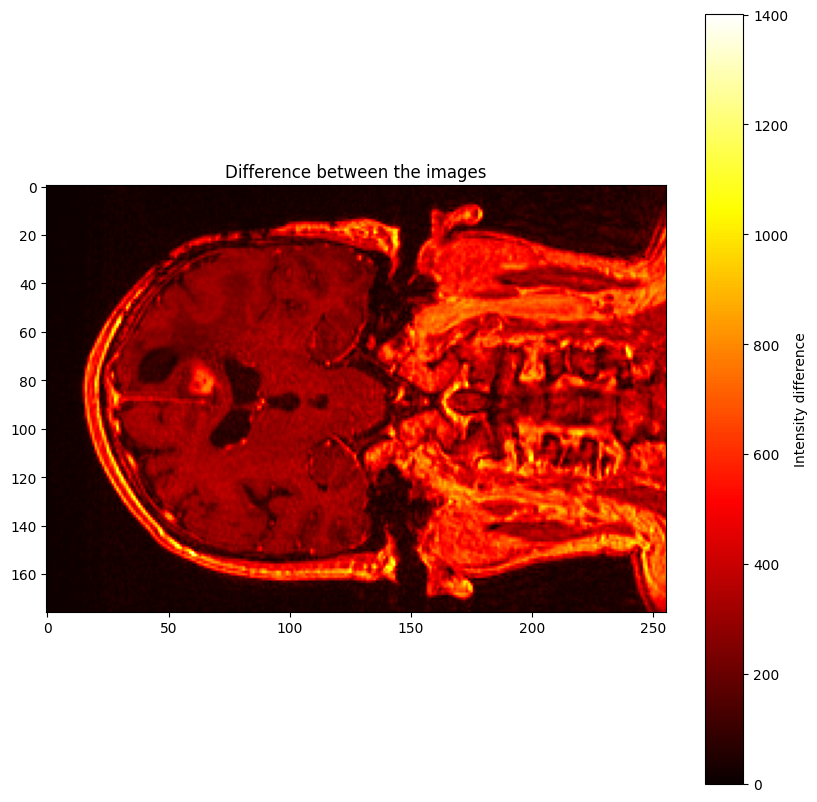

Difference in tumor volume: 61072


In [21]:
# Convert the images to arrays
scan1_array = itk.GetArrayFromImage(scan1)
segmented_image_array = itk.GetArrayFromImage(segmented_image)

# Calculate the intensity difference
diff = np.abs(scan1_array - segmented_image_array)

# Visualisation of intensity difference
plt.figure(figsize=(10, 10))
plt.imshow(diff[:, :, diff.shape[2]//2], cmap='hot')  # we show a central slice
plt.title('Difference between the images')
plt.colorbar(label='Intensity difference')
plt.show()

# Arbitrary threshold to determine whether a voxel is considered part of the tumor
threshold = np.max(diff) * 0.5
tumor_volume_diff = np.sum(diff > threshold)
print('Difference in tumor volume:', tumor_volume_diff)
